In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/Shareddrives/CS670'

/content/drive/Shareddrives/CS670


In [ ]:
%ls


'Copy of Detr_ObjectDetection_V1.ipynb'   eccv_18_all_images_sm.tar.gz   Transformer.ipynb
'Copy of Detr_ObjectDetection_v2.ipynb'   eccv_18_annotation_files/
 eccv_18_all_images_sm/                   eccv_18_annotations.tar.gz


In [ ]:
import json

def load_annotations(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

annotations_directory_path = 'eccv_18_annotation_files/'
train_annotations = load_annotations(f'{annotations_directory_path}train_annotations.json')
test_annotations = load_annotations(f'{annotations_directory_path}cis_test_annotations.json')
val_annotations = load_annotations(f'{annotations_directory_path}cis_val_annotations.json')


# Load Images based on Annotations


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, annotations, images_directory_path, transform=None):
        self.images_directory_path = images_directory_path
        self.transform = transform
        self.annotations = annotations

        # Mapping from image ID to image information
        self.image_id_to_info = {image['id']: image for image in annotations['images']}

        # Mapping from category ID to category name
        self.category_id_to_name = {category['id']: category['name'] for category in annotations['categories']}

        # Assuming each image has only one annotation for simplicity. If there are multiple, this needs adjustment.
        self.image_id_to_annotation = {annotation['image_id']: annotation for annotation in annotations['annotations']}

    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        image_info = self.annotations['images'][idx]
        img_id = image_info['id']
        img_path = os.path.join(self.images_directory_path, image_info['file_name'])

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            print(f"Image not found: {img_path}")
            return None

        if self.transform:
            image = self.transform(image)

        annotation = self.image_id_to_annotation.get(img_id, {})
        category_id = annotation.get('category_id', -1)
        category_name = self.category_id_to_name.get(category_id, 'Unknown')
        bbox = annotation.get('bbox', [0, 0, 0, 0])

        # Transforming bbox to tensor for consistency in PyTorch operations
        bbox_tensor = torch.tensor(bbox, dtype=torch.float32)

        return image, category_name, bbox_tensor

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])



In [ ]:
# Assuming your images are stored in a single directory
images_directory_path = 'eccv_18_all_images_sm/'

# Initialize the dataset
train_dataset = CustomDataset(test_annotations, images_directory_path, transform = transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


# Visualize the Data

Image not found: eccv_18_all_images_sm/58a52ff2-23d2-11e8-a6a3-ec086b02610b.jpg
Image not found: eccv_18_all_images_sm/59df5c9c-23d2-11e8-a6a3-ec086b02610b.jpg


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

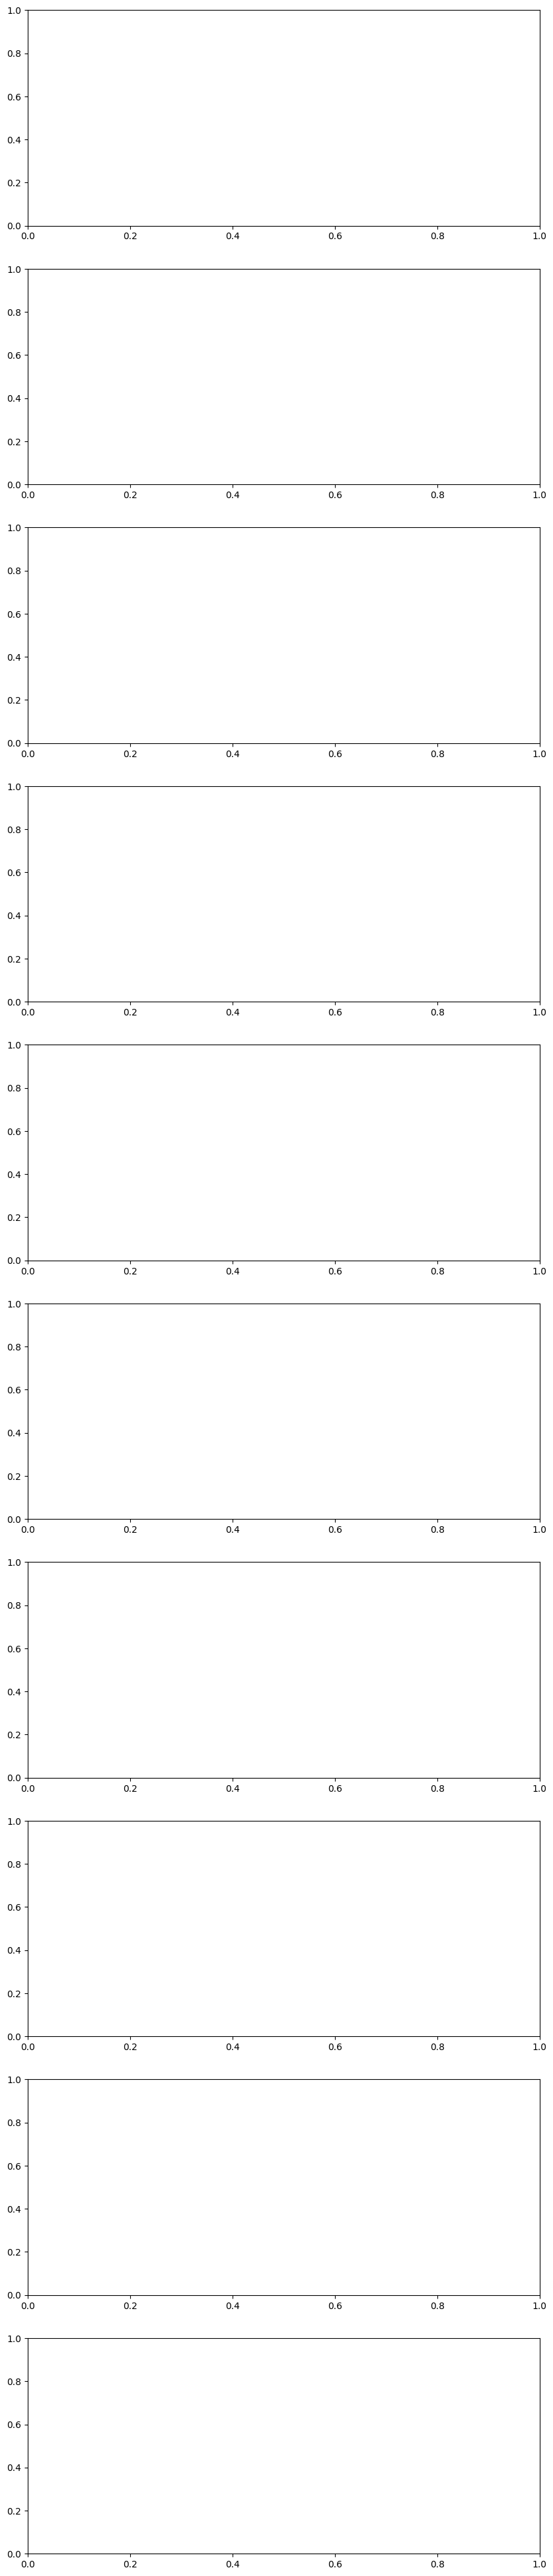

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_images_with_bboxes(data_loader, num_images=10):
    # Set up the figure
    fig, axs = plt.subplots(nrows=num_images, figsize=(10, num_images * 5))

    for i, (image, category, bbox) in enumerate(data_loader):
        print(i)
        if i >= num_images:
            break

        # Convert the tensor image to numpy and transpose the dimensions
        # from [C, H, W] to [H, W, C] for visualization
        img_np = image[0].numpy().transpose((1, 2, 0))

        # Display the image
        axs[i].imshow(img_np)

        #Add the bounding box
        #The bounding box is [x, y, width, height]. Need to adjust for the image size here if necessary.
        rect = patches.Rectangle((bbox[0][0], bbox[0][1]), bbox[0][2], bbox[0][3], linewidth=2, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

        # Add the category name
        axs[i].text(bbox[0][0], bbox[0][1] - 2, category[0], color='red', fontsize=12, backgroundcolor='white')

        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Note: Ensure your DataLoader is not shuffling for this visualization to work predictably
visualize_images_with_bboxes(train_loader)

# Fetch a batch of images
images, _ = next(iter(train_loader))
visualize_images_with_bboxes(images[:4])


In [ ]:
!ls -l eccv_18_all_images_sm/58a1c8e3-23d2-11e8-a6a3-ec086b02610b.jpg

-rw------- 1 root root 161372 Jul  8  2018 eccv_18_all_images_sm/58a1c8e3-23d2-11e8-a6a3-ec086b02610b.jpg


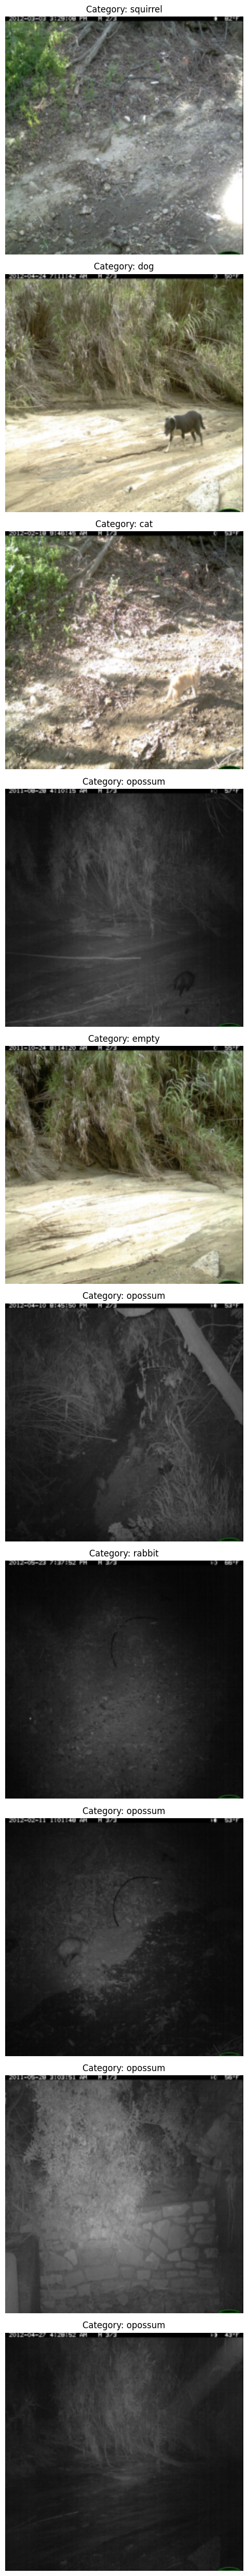

In [ ]:
import matplotlib.pyplot as plt

def plot_images(data_loader, num_images=10):
    fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(5, 5 * num_images))

    for i, (images, categories, bboxes) in enumerate(data_loader):
        for j in range(images.size(0)):
            if i * data_loader.batch_size + j >= num_images:
                break
            ax = axs[i * data_loader.batch_size + j]
            img = images[j].numpy().transpose((1, 2, 0))  # Convert from torch format to image format
            ax.imshow(img)
            ax.axis('off')  # No axes for clarity
            ax.set_title(f"Category: {categories[j]}")
        if i * data_loader.batch_size + j >= num_images - 1:
            break

    plt.tight_layout()
    plt.show()

# Now call the function with the train_loader
plot_images(train_loader,num_images=10)

In [ ]:
from glob import glob

image_files = glob("eccv_18_all_images_sm/*")

len(image_files)

54758

In [ ]:
'eccv_18_all_images_sm/58a1c8e3-23d2-11e8-a6a3-ec086b02610b.jpg' in image_files

True

In [ ]:

import json

# Opening JSON file and loading the data
train_annotations = load_annotations(f'{annotations_directory_path}train_annotations.json')
print(train_annotations['annotations'][0],train_annotations['images'][0])
print(train_annotations['categories'])
#pick id from images key and match it with image_id in annotations.

{'image_id': '5a197af2-23d2-11e8-a6a3-ec086b02610b', 'category_id': 10, 'bbox': [317.44, 747.52, 261.11999999999995, 284.15999999999985], 'id': '19688'} {'file_name': '5a2176e7-23d2-11e8-a6a3-ec086b02610b.jpg', 'rights_holder': 'Justin Brown', 'height': 1494, 'width': 2048, 'frame_num': 2, 'date_captured': '2011-11-29 17:28:26', 'location': 38, 'seq_num_frames': 3, 'seq_id': '6f011019-5567-11e8-a650-dca9047ef277', 'id': '5a2176e7-23d2-11e8-a6a3-ec086b02610b'}
[{'id': 6, 'name': 'bobcat'}, {'id': 1, 'name': 'opossum'}, {'id': 30, 'name': 'empty'}, {'id': 9, 'name': 'coyote'}, {'id': 3, 'name': 'raccoon'}, {'id': 11, 'name': 'bird'}, {'id': 8, 'name': 'dog'}, {'id': 16, 'name': 'cat'}, {'id': 5, 'name': 'squirrel'}, {'id': 10, 'name': 'rabbit'}, {'id': 7, 'name': 'skunk'}, {'id': 99, 'name': 'rodent'}, {'id': 21, 'name': 'badger'}, {'id': 34, 'name': 'deer'}, {'id': 33, 'name': 'car'}, {'id': 51, 'name': 'fox'}]


In [ ]:
count=0
for annotations in train_annotations['images']:
    if("eccv_18_all_images_sm/"+annotations['file_name'] not in image_files):
      #print("doesnt exist")\
      count+=1

count

713

In [ ]:
len(train_annotations['images'])

13553

In [ ]:
test_annotations = load_annotations(f'{annotations_directory_path}cis_test_annotations.json')
count=0
for annotations in test_annotations['images']:
    if("eccv_18_all_images_sm/"+annotations['file_name'] not in image_files):
      #print("doesnt exist")\
      count+=1

count

850

In [ ]:
len(test_annotations['images'])

15827

In [ ]:
val_annotations = load_annotations(f'{annotations_directory_path}cis_val_annotations.json')
count=0
for annotations in val_annotations['images']:
    if("eccv_18_all_images_sm/"+annotations['file_name'] not in image_files):
      #print("doesnt exist")\
      count+=1

count,len(val_annotations["images"])

(178, 3484)

In [ ]:

cct_annotations_file="eccv_18_annotation_files/train_annotations.json"
cct_images_dir="eccv_18_all_images_sm"
cct= cctParser(cct_annotations_file, cct_images_dir)

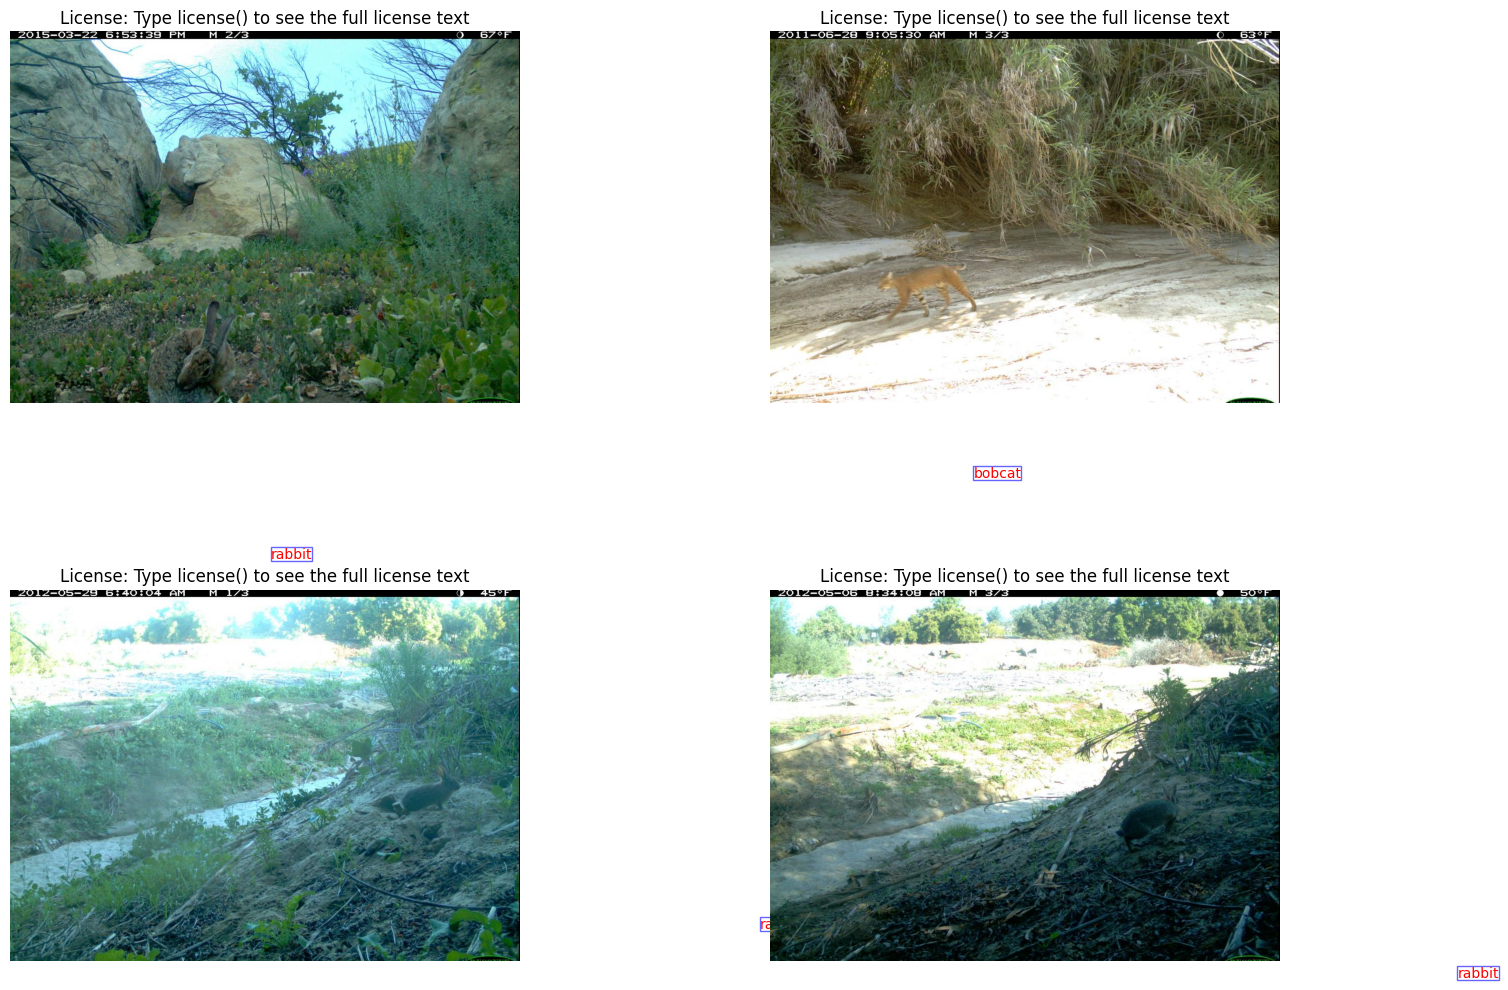

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
num_imgs_to_disp = 4
total_images = len(cct.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
img_ids = cct.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = cct.get_annIds(selected_img_ids)
# im_licenses = cct.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{cct_images_dir}/{str(im).zfill(12)}.jpg")
    ann_ids = cct.get_annIds(im)
    annotations = cct.load_anns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = cct.load_cats(class_id)[0]["name"]
        # license = cct.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)

    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {license}")
plt.tight_layout()
plt.show()

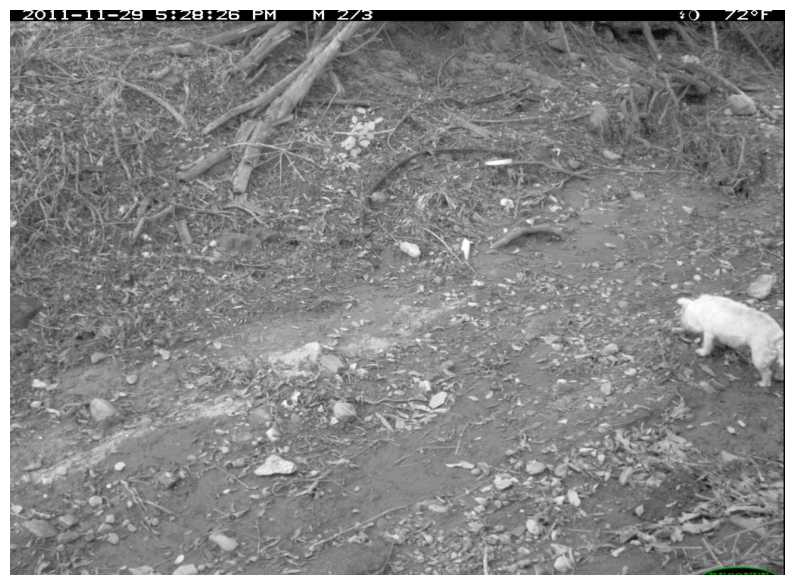

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Assuming Google Drive is already mounted at '/content/drive'
# Set the base path for the dataset
base_path = '/content/drive/Shareddrives/CS670'
image_folder_path = os.path.join(base_path, 'eccv_18_all_images_sm/')
annotation_file_path = os.path.join(base_path, 'eccv_18_annotation_files/train_annotations.json')

# Load the cct annotations file
with open(annotation_file_path, 'r') as f:
    annotations = json.load(f)

# Function to get annotations for a given image_id
def get_annotations_for_image(image_id, annotations):
    return [anno for anno in annotations['annotations'] if anno['image_id'] == image_id]

# Function to visualize a single image and its bounding boxes
def visualize_image(image_id, annotations, image_folder_path):
    # Find image info
    image_info = next((img for img in annotations['images'] if img['id'] == image_id), None)
    if image_info is None:
        print("Image ID not found.")
        return

    # Load and display the image
    image_path = os.path.join(image_folder_path, image_info['file_name'])
    image = Image.open(image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')

    # Draw bounding boxes
    annos = get_annotations_for_image(image_id, annotations)
    ax = plt.gca()
    for anno in annos:
        # cct bbox format: [x, y, width, height]
        bbox = anno['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

    print(annotations)

# Example usage
# Assuming you want to visualize the first image in the dataset
first_image_id = annotations['images'][0]['id']
visualize_image(first_image_id, annotations, image_folder_path)


# Loading the DETR Transformer Model

In [ ]:
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/detr.git


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
from detr import detr
import torch

# Load the pre-trained DETR model
model = detr.detr_resnet50(pretrained=True)
model.eval()

# If using GPU
if torch.cuda.is_available():
    model.to('cuda')


In [ ]:
from PIL import Image
import torchvision.transforms as T

def transform_image(image_path):
    # Define the transformation
    transform = T.Compose([
        T.Resize(800),  # Resize the image to the size DETR expects
        T.ToTensor(),   # Convert the image to a torch tensor
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize it
    ])

    image = Image.open(image_path).convert("RGB")
    # Apply the transformation
    return transform(image).unsqueeze(0)  # Add a batch dimension

# Example image path
image_path = '/content/drive/My Drive/eccv_18_all_images_sm/your_image.jpg'
image = transform_image(image_path)


In [ ]:
# Move image to the correct device
if torch.cuda.is_available():
    image = image.to('cuda')

# Make prediction
with torch.no_grad():
    outputs = model(image)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_prediction(image_path, outputs):
    # Load the original image
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    ax = plt.gca()
    for bbox, label, score in zip(outputs['pred_boxes'][0], outputs['pred_labels'][0], outputs['pred_scores'][0]):
        if score > 0.5:  # Threshold
            x, y, x2, y2 = bbox.cpu().numpy()
            rect = patches.Rectangle((x, y), x2-x, y2-y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, f'{label} {score:.2f}', color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    plt.axis('off')
    plt.show()

visualize_prediction(image_path, outputs)
